In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [3]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Description:

The full data for this project can be found on this website: https://www.kaggle.com/c/ashrae-energy-prediction/data I downloaded this data and placed it in a datafolder that I will read from in this code. After playing with this data where I first resolved NA values in the features columns, I realized that lot of buildings in this data don't have a good meter_reading values. Specificaly 1179 out of 1413 buildings have a bad meter_reading value which would make it hard for us to make predictions based on this bad data. 

So I decided as a first step I will focus on electricity consumption of one building that has good meter reading values and I will try to play with the NN structure on this data in order to understand the power of NN. I could then use the knowledge gained in this part and I can apply it to other buildings too.

### 1. Load data

Load data for all the buildings, select data for building_id = 200 and meter = 'electricity' and choose to have only features that would be important for one building predictions (we don't need primary_use, square_feet, floor_count and year_built features for one building):

In [4]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

In [ ]:
pd_1bld = pd_all.loc[(pd_all["building_id"]==200) & (pd_all["meter"]==0)]
features = ['timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_1bld = pd_1bld[features]
pd_1bld

,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
2433447,2016-01-01 00:00:00,15.6,6.0,-5.6,0.0,1015.3,270.0,3.6,63.09
2433450,2016-01-01 01:00:00,13.9,4.0,-5.6,0.0,1015.6,270.0,4.1,62.36
2433453,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.0,270.0,3.1,62.67
2433456,2016-01-01 03:00:00,12.2,0.0,-6.1,0.0,1016.6,280.0,3.1,61.69
2433459,2016-01-01 04:00:00,11.7,2.0,-6.7,0.0,1017.0,270.0,3.1,61.43
...,...,...,...,...,...,...,...,...,...
2459772,2016-12-31 19:00:00,15.0,4.0,11.1,0.0,1012.4,210.0,3.6,197.55
2459775,2016-12-31 20:00:00,16.1,4.0,10.0,0.0,1011.7,260.0,3.6,199.37
2459778,2016-12-31 21:00:00,16.7,4.0,9.4,0.0,1011.2,240.0,4.6,195.89
2459781,2016-12-31 22:00:00,16.7,6.0,10.0,0.0,1011.0,250.0,3.6,170.58


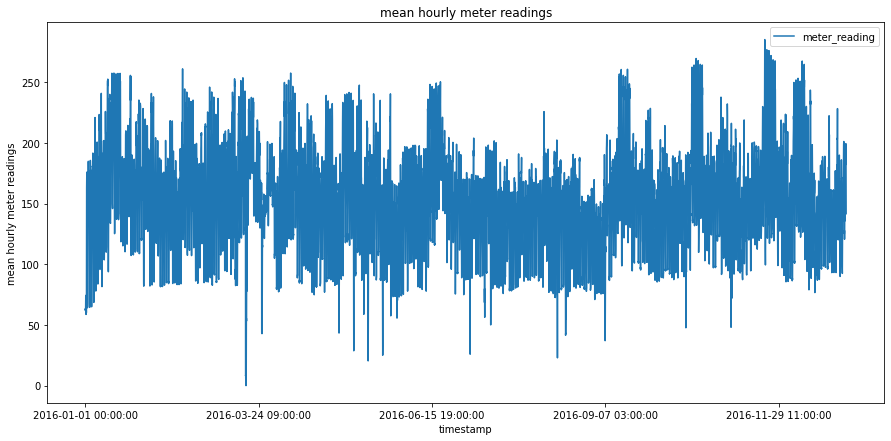

In [ ]:
pd_1bld.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings")

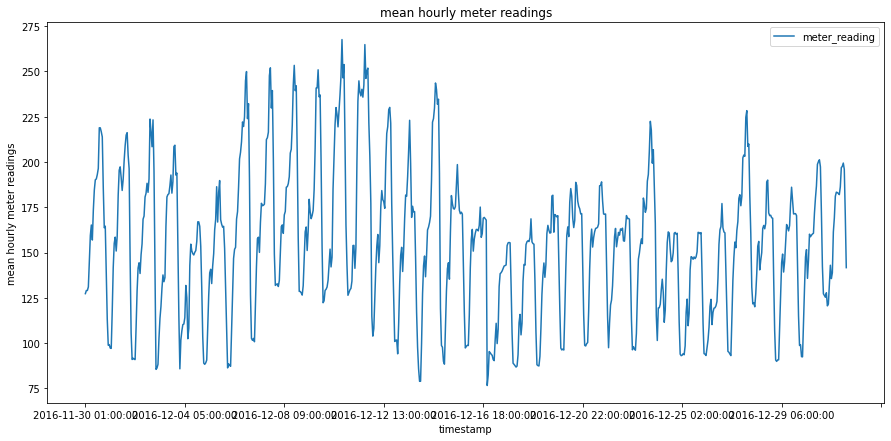

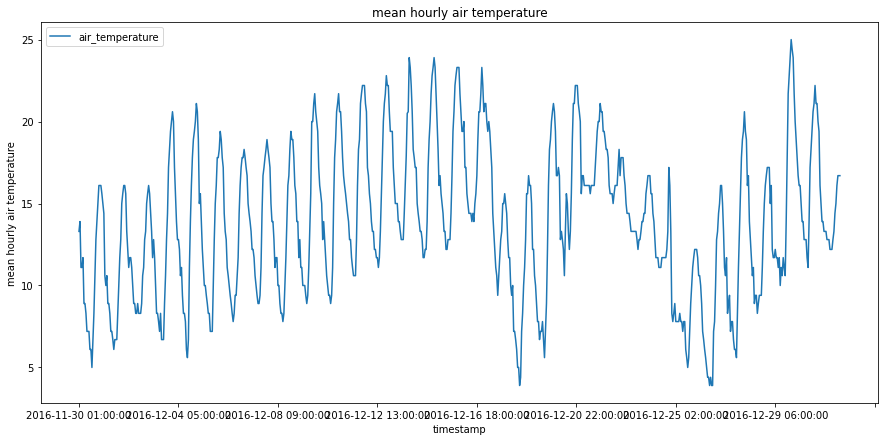

In [ ]:
## Plot data for last month (just to get a feeling how things are changing):
pd_1bld_lm = pd_1bld.loc[pd.to_datetime(pd_1bld["timestamp"]) > datetime.datetime(2016, 11, 30)]
pd_1bld_lm.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings")
pd_1bld_lm.groupby(by = "timestamp").mean().filter(["timestamp", "air_temperature"]).plot(figsize =(15,7), ylabel = "mean hourly air temperature", title = "mean hourly air temperature")


### 2. Split the data into train and test:

I will first split the data into train and test.

In [ ]:
# split it ~91% on train (11 months) and 9% on test (last month)
pd_train = pd_1bld.loc[pd.to_datetime(pd_1bld["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test = pd_1bld.loc[pd.to_datetime(pd_1bld["timestamp"]) > datetime.datetime(2016, 11, 30)]

### 3. Feature encoding for linear regression: 

Before training the data using linear regression we should do feature encoding. I tried two different versions: One where I mostly did numeric feature encoding (numeric encoding) and one where i did more polynomial feature encoding.

#### 3.1. Numeric feature encoding

In [ ]:
# Timestamp feature encoding:
## I am choosing here month, weekday and hour as a way to do feature encoding of 
## timestamp feature given that timestamp has clear dependance on day and month and 
## also it has a clear dependence on weekday (usage is smaller over weekends).
pd_train['month'] = pd.to_datetime(pd_train["timestamp"]).dt.month
pd_test['month'] = pd.to_datetime(pd_test["timestamp"]).dt.month

pd_train['weekday'] = pd.to_datetime(pd_train["timestamp"]).dt.weekday
pd_test['weekday'] = pd.to_datetime(pd_test["timestamp"]).dt.weekday

pd_train['hour'] = pd.to_datetime(pd_train["timestamp"]).dt.hour
pd_test['hour'] = pd.to_datetime(pd_test["timestamp"]).dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
timestamp_train = pd_train.pop('timestamp')
timestamp_test = pd_test.pop('timestamp')

In [ ]:
# Let's look at the train data:
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,8037.0,25.951443,8.772244,2.2,19.40,26.70,32.80,47.20
cloud_coverage,8037.0,2.796690,2.349443,0.0,0.00,2.00,5.00,9.00
dew_temperature,8037.0,4.170269,7.787807,-17.2,-1.70,3.30,10.00,23.30
precip_depth_1_hr,8037.0,0.143088,2.839656,-1.0,0.00,0.00,0.00,132.00
sea_level_pressure,8037.0,1011.254541,4.737828,999.3,1008.10,1010.60,1013.90,1028.20
wind_direction,8037.0,155.576086,102.369715,0.0,90.00,130.00,250.00,360.00
wind_speed,8037.0,2.998855,1.961954,0.0,2.10,2.60,4.10,15.40
meter_reading,8037.0,154.996937,40.980551,0.0,128.53,158.23,179.82,285.22
month,8037.0,6.006595,3.158116,1.0,3.00,6.00,9.00,11.00
weekday,8037.0,3.000871,2.002891,0.0,1.00,3.00,5.00,6.00


In [ ]:
# Normalize the data before we send it to linear regression model to learn this data:
## Note: we want to normalize test data using same mean and std as train!!!!
train_mean = pd_train.mean()
train_std = pd_train.std()

pd_train = (pd_train - train_mean) / train_std
pd_test = (pd_test- train_mean) / train_std

# We can now compare if our normalization worked (by comparing it to the cell above):
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,8037.0,4.266284e-16,1.0,-2.707568,-0.746838,0.085332,0.780708,2.422249
cloud_coverage,8037.0,-9.229894e-16,1.0,-1.190363,-1.190363,-0.339097,0.937801,2.640332
dew_temperature,8037.0,-3.861510e-15,1.0,-2.744067,-0.753777,-0.111748,0.748572,2.456369
precip_depth_1_hr,8037.0,-5.808848e-16,1.0,-0.402545,-0.050389,-0.050389,-0.050389,46.434119
sea_level_pressure,8037.0,-1.830927e-13,1.0,-2.523211,-0.665820,-0.138152,0.558369,3.576630
wind_direction,8037.0,1.345750e-15,1.0,-1.519747,-0.640581,-0.249840,0.922381,1.996918
wind_speed,8037.0,9.379768e-14,1.0,-1.528504,-0.458143,-0.203295,0.561249,6.320813
meter_reading,8037.0,2.283310e-14,1.0,-3.782207,-0.645841,0.078893,0.605728,3.177680
month,8037.0,-3.091722e-14,1.0,-1.585310,-0.952021,-0.002088,0.947845,1.581134
weekday,8037.0,-1.041154e-16,1.0,-1.498270,-0.998991,-0.000435,0.998122,1.497400


##### 3.1.1. Split data into features and labels:

In [ ]:
train_features = pd_train.copy()
test_features = pd_test.copy()

train_labels = train_features.pop('meter_reading')
test_labels = test_features.pop('meter_reading')

##### 3.1.2. Linear regression on this data when all the features are encoded using numeric encoding:

In [ ]:
linear_regression_model = keras.models.Sequential([
    layers.Dense(units=1) # Linear Model
])

loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.001) #learning is super dependent on learning rate, for 0.01 it didn't learn well
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [ ]:
history = linear_regression_model.fit(
    train_features, train_labels,
    epochs=20,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/20
201/201 [==============================] - 1s 2ms/step - loss: 1.9951 - val_loss: 1.2999
Epoch 2/20
201/201 [==============================] - 0s 2ms/step - loss: 1.2263 - val_loss: 0.8876
Epoch 3/20
201/201 [==============================] - 0s 2ms/step - loss: 0.8874 - val_loss: 0.6705
Epoch 4/20
201/201 [==============================] - 0s 2ms/step - loss: 0.6859 - val_loss: 0.5680
Epoch 5/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5996 - val_loss: 0.5275
Epoch 6/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5614 - val_loss: 0.5152
Epoch 7/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5471 - val_loss: 0.5156
Epoch 8/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5104 - val_loss: 0.5199
Epoch 9/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5129 - val_loss: 0.5255
Epoch 10/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5273 - val_loss: 0.5314

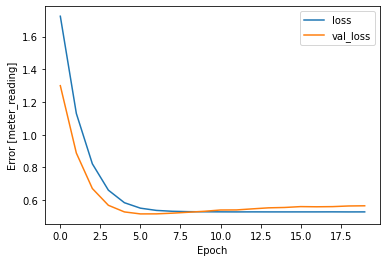

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [ ]:
linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)

24/24 [==============================] - 0s 1ms/step - loss: 1.2660


1.2659814357757568

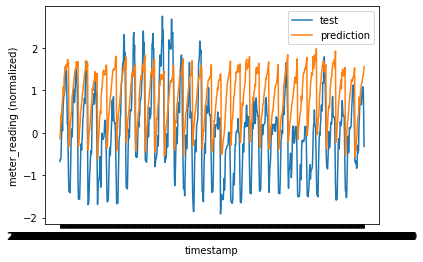

In [ ]:
y = linear_regression_model.predict(test_features)
    
plt.plot(timestamp_test,test_labels, label = 'test')
plt.plot(timestamp_test,y, label = 'prediction')#*np.std(train_labels)+ np.mean(train_labels), label = 'prediction')
plt.ylabel('meter_reading (normalized)')
plt.xlabel('timestamp')
plt.legend()
plt.show()

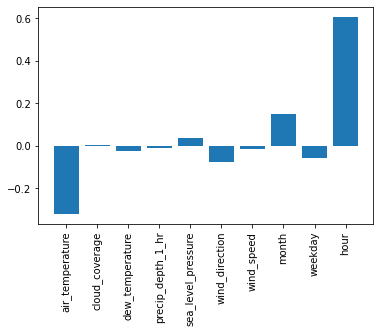

In [ ]:
plt.bar(x = range(len(train_features.columns)),
        height=linear_regression_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_features.columns)))
_ = axis.set_xticklabels(train_features.columns, rotation=90)

#### 3.2. Polynomial and numeric feature encoding:

In this part I would like to encode some features using polynomial encoding and some using regular numeric feature encoding:

##### 3.2.1. Do polynomial feature encoding for wind and timestamp features:

In [ ]:
# Wind direction:
## Wind direction should not be encoded as a numeric feature because 360 deg and 
## 0 deg are close in actual value (because of 2pi wrapping) but with numeric encoding 
## they will look far from each other. I will make a new features instead wx and wy that
## will combine wind speed and direction and put them as wind along x and y instead:
pd_1bld = pd_all.loc[(pd_all["building_id"]==200) & (pd_all["meter"]==0)]
features = ['timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_polnorm = pd_1bld[features]


wind_speed = pd_polnorm.pop('wind_speed')
wind_direction = pd_polnorm.pop('wind_direction')*np.pi/180 # wind direction in radians

pd_polnorm['wind_x'] = wind_speed * np.cos(wind_direction)
pd_polnorm['wind_y'] = wind_speed * np.sin(wind_direction)


# Timestamp feature encoding:
timestamp = pd.to_datetime(pd_polnorm["timestamp"]).map(datetime.datetime.timestamp)
day = 24*60*60
week = 7*day
month = 30*day
year = (365.2425)*day
pd_polnorm['day_sin'] = np.sin(timestamp * (2 * np.pi / day))
pd_polnorm['day_cos'] = np.cos(timestamp * (2 * np.pi / day))

pd_polnorm['week_sin'] = np.sin(timestamp * (2 * np.pi / week))
pd_polnorm['week_cos'] = np.cos(timestamp * (2 * np.pi / week))

pd_polnorm['month_sin'] = np.sin(timestamp * (2 * np.pi / month))
pd_polnorm['month_cos'] = np.cos(timestamp * (2 * np.pi / month))

pd_polnorm['year_sin'] = np.sin(timestamp * (2 * np.pi / year))
pd_polnorm['year_cos'] = np.cos(timestamp * (2 * np.pi / year))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

##### 3.2.2. Split the data into train and test:

In [ ]:
# split it ~91% on train (11 months) and 9% on test (last month)
pd_train = pd_polnorm.loc[pd.to_datetime(pd_polnorm["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test = pd_polnorm.loc[pd.to_datetime(pd_polnorm["timestamp"]) > datetime.datetime(2016, 11, 30)]

timestamp_train = pd_train.pop('timestamp')
timestamp_test = pd_test.pop('timestamp')

##### 3.2.3. Do numeric encoding (normalize data) using just training data:

In [ ]:
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,8037.0,25.951443,8.772244,2.2,19.400000,2.670000e+01,32.800000,47.20000
cloud_coverage,8037.0,2.796690,2.349443,0.0,0.000000,2.000000e+00,5.000000,9.00000
dew_temperature,8037.0,4.170269,7.787807,-17.2,-1.700000,3.300000e+00,10.000000,23.30000
precip_depth_1_hr,8037.0,0.143088,2.839656,-1.0,0.000000,0.000000e+00,0.000000,132.00000
sea_level_pressure,8037.0,1011.254541,4.737828,999.3,1008.100000,1.010600e+03,1013.900000,1028.20000
meter_reading,8037.0,154.996937,40.980551,0.0,128.530000,1.582300e+02,179.820000,285.22000
wind_x,8037.0,-0.336155,1.885627,-11.8,-1.300000,-1.322619e-15,0.513030,11.80000
wind_y,8037.0,-0.033868,3.028822,-15.4,-2.068096,0.000000e+00,2.300000,10.14868
day_sin,8037.0,-0.000017,0.707173,-1.0,-0.707107,6.617561e-14,0.707107,1.00000
day_cos,8037.0,-0.000153,0.707129,-1.0,-0.707107,-2.647910e-14,0.707107,1.00000


In [ ]:
# Normalize the data before we send it to linear regression model to learn this data:
## Note: we want to normalize test data using same mean and std as train!!!!
train_mean = pd_train.mean()
train_std = pd_train.std()

pd_train = (pd_train - train_mean) / train_std
pd_test = (pd_test- train_mean) / train_std

# We can now compare if our normalization worked (by comparing it to the cell above):
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
air_temperature,8037.0,4.266284e-16,1.0,-2.707568,-0.746838,0.085332,0.780708,2.422249
cloud_coverage,8037.0,-9.229894e-16,1.0,-1.190363,-1.190363,-0.339097,0.937801,2.640332
dew_temperature,8037.0,-3.861510e-15,1.0,-2.744067,-0.753777,-0.111748,0.748572,2.456369
precip_depth_1_hr,8037.0,-5.808848e-16,1.0,-0.402545,-0.050389,-0.050389,-0.050389,46.434119
sea_level_pressure,8037.0,-1.830927e-13,1.0,-2.523211,-0.665820,-0.138152,0.558369,3.576630
meter_reading,8037.0,2.283310e-14,1.0,-3.782207,-0.645841,0.078893,0.605728,3.177680
wind_x,8037.0,2.481639e-15,1.0,-6.079593,-0.511153,0.178272,0.450346,6.436138
wind_y,8037.0,4.301510e-16,1.0,-5.073303,-0.671624,0.011182,0.770553,3.361884
day_sin,8037.0,3.074283e-17,1.0,-1.414058,-0.999883,0.000024,0.999930,1.414105
day_cos,8037.0,1.298506e-17,1.0,-1.413953,-0.999752,0.000217,1.000186,1.414386


##### 3.2.4. Split the data into features and labels:

In [ ]:
train_features = pd_train.copy()
test_features = pd_test.copy()

train_labels = train_features.pop('meter_reading')
test_labels = test_features.pop('meter_reading')

##### 3.2.5. Let's perform linear regression on this data:

In [ ]:
linear_regression_model = keras.models.Sequential([
    layers.Dense(units=1) # Linear Model
])

loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.001) 
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [ ]:
history = linear_regression_model.fit(
    train_features, train_labels,
    batch_size=32,
    epochs=20,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/20
201/201 [==============================] - 1s 3ms/step - loss: 2.1316 - root_mean_squared_error: 1.4590 - val_loss: 1.5029 - val_root_mean_squared_error: 1.2259
Epoch 2/20
201/201 [==============================] - 0s 2ms/step - loss: 1.3876 - root_mean_squared_error: 1.1774 - val_loss: 1.1301 - val_root_mean_squared_error: 1.0631
Epoch 3/20
201/201 [==============================] - 0s 2ms/step - loss: 1.0354 - root_mean_squared_error: 1.0171 - val_loss: 0.9136 - val_root_mean_squared_error: 0.9558
Epoch 4/20
201/201 [==============================] - 0s 2ms/step - loss: 0.8111 - root_mean_squared_error: 0.9001 - val_loss: 0.7824 - val_root_mean_squared_error: 0.8846
Epoch 5/20
201/201 [==============================] - 0s 2ms/step - loss: 0.6479 - root_mean_squared_error: 0.8046 - val_loss: 0.7003 - val_root_mean_squared_error: 0.8369
Epoch 6/20
201/201 [==============================] - 0s 2ms/step - loss: 0.5659 - root_mean_squared_error: 0.7519 - val_loss: 0.6470 - val_

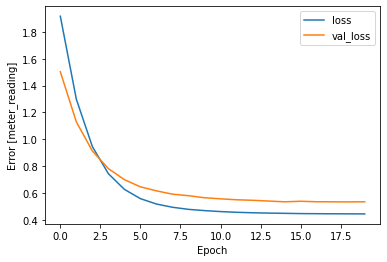

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [ ]:
linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)

24/24 [==============================] - 0s 1ms/step - loss: 0.4387 - root_mean_squared_error: 0.6623


[0.4386848509311676, 0.6623328924179077]

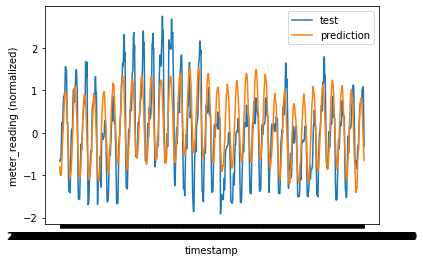

In [ ]:
y = linear_regression_model.predict(test_features)
    
plt.plot(timestamp_test,test_labels, label = 'test')
plt.plot(timestamp_test,y, label = 'prediction')#*np.std(train_labels)+ np.mean(train_labels), label = 'prediction')
plt.ylabel('meter_reading (normalized)')
plt.xlabel('timestamp')
plt.legend()
plt.show()

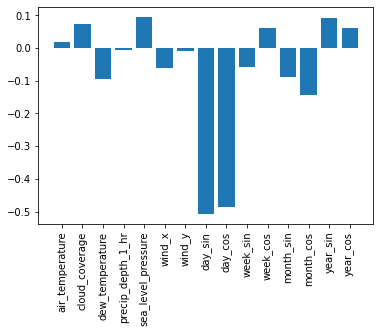

In [ ]:
plt.bar(x = range(len(train_features.columns)),
        height=linear_regression_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_features.columns)))
_ = axis.set_xticklabels(train_features.columns, rotation=90)

### 4. Linear regression on more buildings:

Let's try to do linear regression fit with the second model on all the educational building data for electricity that has good meter_reading values:

In [5]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
# Choose features we care about:
features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

In [6]:
pd_educational

,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,72102,1970.0,5.0,2016-01-01 00:00:00,15.6,6.0,-5.6,0.0,1015.30,270.0,3.6,77.610
1707553,72102,1970.0,5.0,2016-01-01 01:00:00,13.9,4.0,-5.6,0.0,1015.60,270.0,4.1,75.830
1707556,72102,1970.0,5.0,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.00,270.0,3.1,80.570
1707559,72102,1970.0,5.0,2016-01-01 03:00:00,12.2,0.0,-6.1,0.0,1016.60,280.0,3.1,81.530
1707562,72102,1970.0,5.0,2016-01-01 04:00:00,11.7,2.0,-6.7,0.0,1017.00,270.0,3.1,83.550
...,...,...,...,...,...,...,...,...,...,...,...,...
20068262,30143,1951.0,5.0,2016-12-31 19:00:00,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,245.675
20068263,30143,1951.0,5.0,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,250.125
20068264,30143,1951.0,5.0,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,247.875
20068265,30143,1951.0,5.0,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,247.575


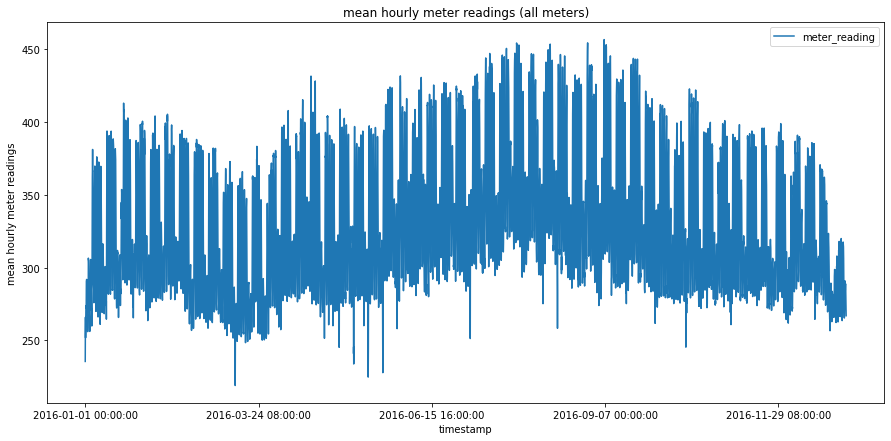

In [7]:
pd_educational.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

#### 4.1. Let's do feature encoding:

In [8]:
# Wind feature encoding:
wind_speed = pd_educational.pop('wind_speed')
wind_direction = pd_educational.pop('wind_direction')*np.pi/180 # wind direction in radians

pd_educational['wind_x'] = wind_speed * np.cos(wind_direction)
pd_educational['wind_y'] = wind_speed * np.sin(wind_direction)


# Timestamp feature encoding:
timestamp = pd.to_datetime(pd_educational["timestamp"]).map(datetime.datetime.timestamp)
day = 24*60*60
week = 7*day
month = 30*day
year = (365.2425)*day
pd_educational['day_sin'] = np.sin(timestamp * (2 * np.pi / day))
pd_educational['day_cos'] = np.cos(timestamp * (2 * np.pi / day))

pd_educational['week_sin'] = np.sin(timestamp * (2 * np.pi / week))
pd_educational['week_cos'] = np.cos(timestamp * (2 * np.pi / week))

#pd_educational['month_sin'] = np.sin(timestamp * (2 * np.pi / month))
#pd_educational['month_cos'] = np.cos(timestamp * (2 * np.pi / month))

pd_educational['year_sin'] = np.sin(timestamp * (2 * np.pi / year))
pd_educational['year_cos'] = np.cos(timestamp * (2 * np.pi / year))

pd_educational['is_weekday'] = (pd.to_datetime(pd_educational["timestamp"]).dt.weekday.values < 5).astype(int)


# Year_built feature encoding:
## Looking at the year_built histogram, there seems to be 3 waves of building
## '1900-1940', '1940-1980', '1980-today'. I will split this column in those 
## 3 features and I will assign them values 0, 1 and 2:
year_built = pd_educational.pop('year_built')
pd_educational['year_built_range'] = ((year_built.values-1900)/40).astype(int)
#bins = [0,1940, 1980, np.inf] 
#names = ['1900-1940', '1940-1980', '1980-today']

#pd_educational['year_range'] = pd.cut(pd_educational['year_built'], bins, labels=names)
#year_built = pd_educational.pop('year_built')

#### 4.2. Split the data into train and test before normalization:



In [9]:
# split it ~91% on train (11 months) and 9% on test (1 month)
#pd_train = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 12, 1)]
#pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 11, 30)]
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

timestamp_train = pd_train.pop('timestamp')
timestamp_test = pd_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### 4.3. Do numeric encoding (normalize data) using training data:

In [10]:
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
square_feet,903124.0,136176.096632,88722.649598,7781.000000,69600.000000,1.042940e+05,193294.000000,420885.000000
floor_count,903124.0,5.317437,1.636649,1.000000,5.000000,5.000000e+00,5.000000,14.000000
air_temperature,903124.0,14.916873,10.251262,-28.900000,8.300000,1.500000e+01,21.700000,44.400000
cloud_coverage,903124.0,3.525971,2.680301,0.000000,2.000000,3.000000e+00,6.000000,9.000000
dew_temperature,903124.0,6.257258,8.979332,-31.700000,0.000000,7.200000e+00,12.800000,26.100000
precip_depth_1_hr,903124.0,1.004031,5.953100,-1.000000,0.000000,0.000000e+00,0.000000,333.000000
sea_level_pressure,903124.0,1016.019181,7.317511,968.200000,1011.600000,1.016100e+03,1020.500000,1042.600000
meter_reading,903124.0,329.382364,380.877142,0.000000,98.320000,1.871500e+02,445.190000,5654.510000
wind_x,903124.0,-0.237155,2.963176,-16.249328,-1.991716,0.000000e+00,1.550000,15.035082
wind_y,903124.0,-0.852053,3.221131,-18.218943,-2.850000,-1.518562e-15,1.402283,13.531574


In [13]:
# Normalize the data before we send it to linear regression model to learn this data:
## Note: we want to normalize test data using same mean and std as train!!!!
train_mean = pd_train.mean()
train_std = pd_train.std()

pd_train = (pd_train - train_mean) / train_std
#pd_train.is_weekday = pd_train.is_weekday*train_std.is_weekday + train_mean.is_weekday
pd_test = (pd_test- train_mean) / train_std
#pd_test.is_weekday = pd_test.is_weekday*train_std.is_weekday + train_mean.is_weekday


# We can now compare if our normalization worked (by comparing it to the cell above):
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
square_feet,903124.0,8.474034e-14,1.0,-1.447151,-0.750384,-0.359346,0.643780,3.208977
floor_count,903124.0,-3.890529e-13,1.0,-2.637974,-0.193956,-0.193956,-0.193956,5.305086
air_temperature,903124.0,3.468419e-13,1.0,-4.274291,-0.645469,0.008109,0.661687,2.876048
cloud_coverage,903124.0,-4.415413e-14,1.0,-1.315513,-0.569328,-0.196236,0.923042,2.042319
dew_temperature,903124.0,1.587912e-13,1.0,-4.227181,-0.696851,0.104990,0.728645,2.209824
precip_depth_1_hr,903124.0,-9.848625e-13,1.0,-0.336637,-0.168657,-0.168657,-0.168657,55.768588
sea_level_pressure,903124.0,-1.647724e-11,1.0,-6.534897,-0.603918,0.011045,0.612342,3.632494
meter_reading,903124.0,-9.178486e-15,1.0,-0.864800,-0.606659,-0.373434,0.304055,13.981221
wind_x,903124.0,7.918090e-15,1.0,-5.403721,-0.592122,0.080034,0.603121,5.154010
wind_y,903124.0,7.038506e-14,1.0,-5.391551,-0.620263,0.264520,0.699858,4.465396


#### 4.5. Split the data into features and labels:

In [14]:
train_features = pd_train.copy()
test_features = pd_test.copy()

train_labels = train_features.pop('meter_reading')
test_labels = test_features.pop('meter_reading')

#### 4.6. Linear regression on multiple building datas:

In [15]:
linear_regression_model = keras.models.Sequential([
    layers.Dense(units=1) # Linear Model
])

loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.00003) 
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [16]:
history = linear_regression_model.fit(
    train_features, train_labels,
    batch_size=256,
    epochs=15,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/15
2823/2823 [==============================] - 8s 2ms/step - loss: 2.2344 - val_loss: 2.1356
Epoch 2/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.7129 - val_loss: 1.7679
Epoch 3/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.3498 - val_loss: 1.4711
Epoch 4/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.0935 - val_loss: 1.2352
Epoch 5/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.9161 - val_loss: 1.0627
Epoch 6/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.7948 - val_loss: 0.9454
Epoch 7/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.7227 - val_loss: 0.8644
Epoch 8/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6724 - val_loss: 0.8063
Epoch 9/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6251 - val_loss: 0.7619
Epoch 10/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.611

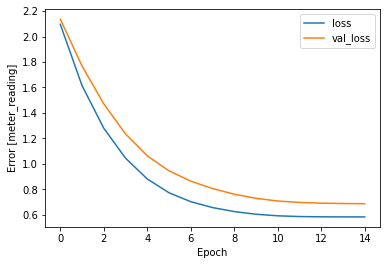

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [18]:
linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)

2536/2536 [==============================] - 4s 1ms/step - loss: 0.7396


0.7395759224891663

In [19]:
test_features_new = test_features.copy()
y = linear_regression_model.predict(test_features_new)
y_norm= pd.DataFrame(y, columns = ['prediction'])
y_norm['timestamp'] = np.array(timestamp_test)
test_features_new['meter_reading']  = test_labels
test_features_new['timestamp']  = np.array(timestamp_test)

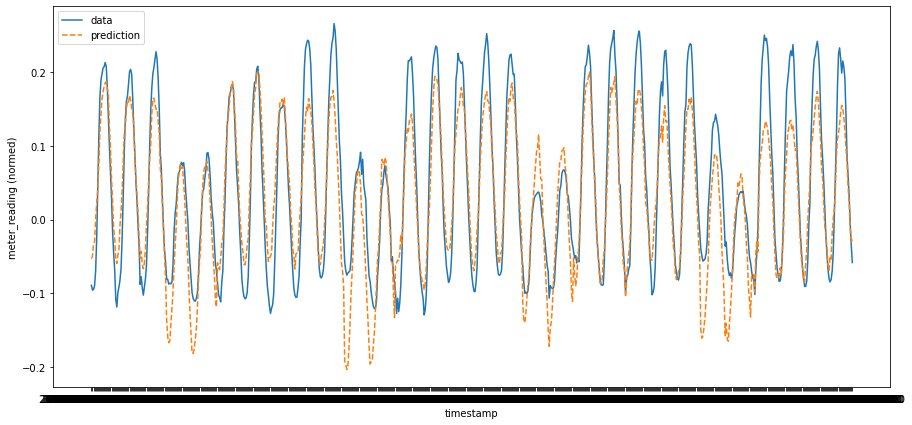

In [20]:
from matplotlib.pyplot import figure
figure(figsize =(15,7))
plt.plot(test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), label = 'data')
plt.plot(y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]),'--', label = 'prediction')
plt.xlabel('timestamp')
plt.ylabel('meter_reading (normed)')
plt.legend()
plt.show()

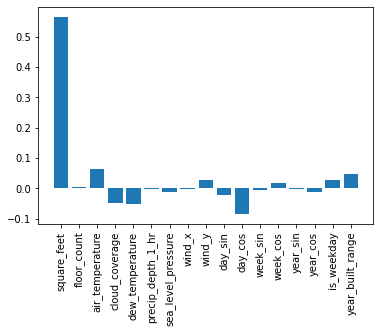

In [ ]:
plt.bar(x = range(len(train_features.columns)),
        height=linear_regression_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_features.columns)))
_ = axis.set_xticklabels(train_features.columns, rotation=90)

### 5. Linear regression on more buildings (no polynomial feature encoding):

In [24]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
# Choose features we care about:
features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

#### 5.1. Feature encoding:

In [25]:
# Timestamp feature encoding:
## I am choosing here month, weekday and hour as a way to do feature encoding of 
## timestamp feature given that timestamp has clear dependance on day and month and 
## also it has a clear dependence on weekday (usage is smaller over weekends).
pd_educational['month'] = pd.to_datetime(pd_educational["timestamp"]).dt.month
pd_educational['weekday'] = pd.to_datetime(pd_educational["timestamp"]).dt.weekday
pd_educational['hour'] = pd.to_datetime(pd_educational["timestamp"]).dt.hour


#### 5.1.2. Split data into trainging and test before normalizing all data:

In [26]:
# split it ~91% on train (11 months) and 9% on test (1 month)
#pd_train = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 12, 1)]
#pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 11, 30)]
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

timestamp_train = pd_train.pop('timestamp')
timestamp_test = pd_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### 5.1.3. Normalize all data:

In [27]:
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
square_feet,903124.0,136176.096632,88722.649598,7781.0,69600.00,104294.00,193294.00,420885.00
year_built,903124.0,1963.153076,27.743020,1903.0,1957.00,1963.00,1970.00,2016.00
floor_count,903124.0,5.317437,1.636649,1.0,5.00,5.00,5.00,14.00
air_temperature,903124.0,14.916873,10.251262,-28.9,8.30,15.00,21.70,44.40
cloud_coverage,903124.0,3.525971,2.680301,0.0,2.00,3.00,6.00,9.00
dew_temperature,903124.0,6.257258,8.979332,-31.7,0.00,7.20,12.80,26.10
precip_depth_1_hr,903124.0,1.004031,5.953100,-1.0,0.00,0.00,0.00,333.00
sea_level_pressure,903124.0,1016.019181,7.317511,968.2,1011.60,1016.10,1020.50,1042.60
wind_direction,903124.0,179.880775,109.420324,0.0,90.00,190.00,280.00,360.00
wind_speed,903124.0,3.724307,2.463301,0.0,2.10,3.10,5.10,19.00


In [28]:
# Normalize the data before we send it to linear regression model to learn this data:
## Note: we want to normalize test data using same mean and std as train!!!!
train_mean = pd_train.mean()
train_std = pd_train.std()

pd_train = (pd_train - train_mean) / train_std
pd_test = (pd_test- train_mean) / train_std

# We can now compare if our normalization worked (by comparing it to the cell above):
pd_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
square_feet,903124.0,8.474034e-14,1.0,-1.447151,-0.750384,-0.359346,0.643780,3.208977
year_built,903124.0,2.117013e-13,1.0,-2.168224,-0.221788,-0.005518,0.246798,1.904873
floor_count,903124.0,-3.890529e-13,1.0,-2.637974,-0.193956,-0.193956,-0.193956,5.305086
air_temperature,903124.0,3.468419e-13,1.0,-4.274291,-0.645469,0.008109,0.661687,2.876048
cloud_coverage,903124.0,-4.415413e-14,1.0,-1.315513,-0.569328,-0.196236,0.923042,2.042319
dew_temperature,903124.0,1.587912e-13,1.0,-4.227181,-0.696851,0.104990,0.728645,2.209824
precip_depth_1_hr,903124.0,-9.848625e-13,1.0,-0.336637,-0.168657,-0.168657,-0.168657,55.768588
sea_level_pressure,903124.0,-1.647724e-11,1.0,-6.534897,-0.603918,0.011045,0.612342,3.632494
wind_direction,903124.0,-6.440173e-14,1.0,-1.643943,-0.821427,0.092480,0.914997,1.646122
wind_speed,903124.0,-1.466757e-11,1.0,-1.511917,-0.659403,-0.253443,0.558475,6.201310


#### 5.1.4. Split data into features and labels:

In [29]:
train_features = pd_train.copy()
test_features = pd_test.copy()

train_labels = train_features.pop('meter_reading')
test_labels = test_features.pop('meter_reading')

#### 5.2. Linear regression learning:

In [30]:
linear_regression_model = keras.models.Sequential([
    layers.Dense(units=1) # Linear Model
])

loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.00003) 
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [31]:
history = linear_regression_model.fit(
    train_features, train_labels,
    batch_size=256,
    epochs=15,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/15
2823/2823 [==============================] - 6s 2ms/step - loss: 2.0346 - val_loss: 2.0085
Epoch 2/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.5752 - val_loss: 1.5900
Epoch 3/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.2431 - val_loss: 1.2791
Epoch 4/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.0066 - val_loss: 1.0581
Epoch 5/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.8369 - val_loss: 0.9088
Epoch 6/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.7256 - val_loss: 0.8158
Epoch 7/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6544 - val_loss: 0.7636
Epoch 8/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6140 - val_loss: 0.7325
Epoch 9/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.5993 - val_loss: 0.7139
Epoch 10/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.587

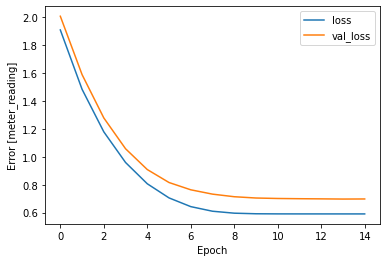

In [32]:
plot_loss(history)

In [33]:
linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)

2536/2536 [==============================] - 4s 1ms/step - loss: 0.7481


0.7481427192687988

In [34]:
test_features_new = test_features.copy()
y = linear_regression_model.predict(test_features_new)
y_norm= pd.DataFrame(y, columns = ['prediction'])
y_norm['timestamp'] = np.array(timestamp_test)
test_features_new['meter_reading']  = test_labels
test_features_new['timestamp']  = np.array(timestamp_test)

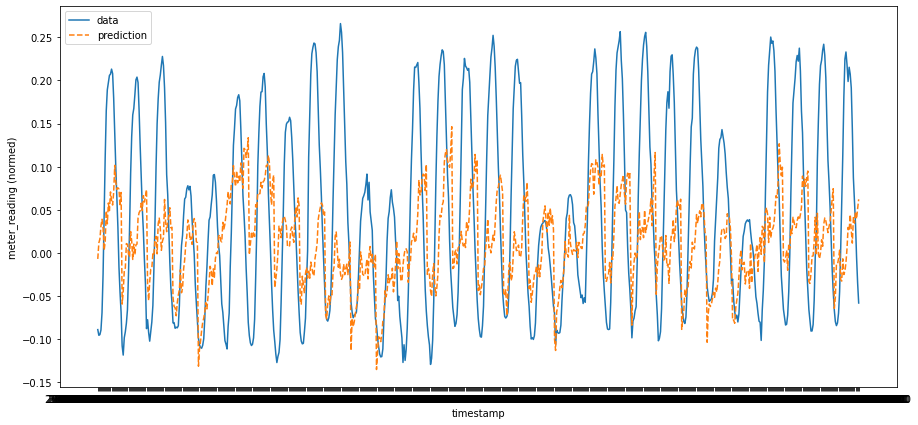

In [35]:
from matplotlib.pyplot import figure
figure(figsize =(15,7))
plt.plot(test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), label = 'data')
plt.plot(y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]),'--', label = 'prediction')
plt.xlabel('timestamp')
plt.ylabel('meter_reading (normed)')
plt.legend()
plt.show()

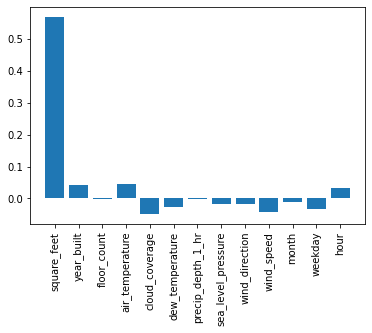

In [36]:
plt.bar(x = range(len(train_features.columns)),
        height=linear_regression_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_features.columns)))
_ = axis.set_xticklabels(train_features.columns, rotation=90)

### 6. Let's make compact functions:
This will help the main code to be more readable..

In [16]:
def load_electricity_education(pd_all):
  # Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
  pd_educational = pd_all.copy()
  pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
  pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
  # Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
  drop_ids = np.loadtxt('dropids.txt')
  pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
  # Choose features we care about:
  features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
  pd_educational = pd_educational[features]
  return pd_educational

In [17]:
def prepare_data_simple_encoding(pd_dataframe):
  # Timestamp feature encoding:
    ## Looking at the data during data exploration, data shows clear dependence on
    ## time of the day and weekend/weekday. There is also some month variation
    ## of the meter_reading data. I will thus split the timestamp data into month,
    ## weekday and hour that I will then encode using regular numeric encoding (normalize)
  pd_educational = pd_dataframe.copy()
  pd_educational['month'] = pd.to_datetime(pd_educational["timestamp"]).dt.month
  pd_educational['weekday'] = pd.to_datetime(pd_educational["timestamp"]).dt.weekday
  pd_educational['hour'] = pd.to_datetime(pd_educational["timestamp"]).dt.hour

  pd_train, pd_test, timestamp_train, timestamp_test = split_data(pd_educational)

  # Normalize the data before we send it to linear regression model to learn this data:
  ## Note: we want to normalize test data using same mean and std as train!
  train_mean = pd_train.mean()
  train_std = pd_train.std()

  pd_train = (pd_train - train_mean) / train_std
  pd_test = (pd_test- train_mean) / train_std

  train_features = pd_train.copy()
  test_features = pd_test.copy()

  train_labels = train_features.pop('meter_reading')
  test_labels = test_features.pop('meter_reading')

  return (train_features,train_labels), (test_features,test_labels), timestamp_train, timestamp_test

In [18]:
def split_data(pd_dataframe):
  # split it ~90% on train + validation (11 months) and ~10% on test (1 month)
  pd_educational = pd_dataframe.copy()
  pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
  pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

  timestamp_train = pd_train.pop('timestamp')
  timestamp_test = pd_test.pop('timestamp')

  return pd_train, pd_test, timestamp_train, timestamp_test

In [19]:
def prepare_data_polynomial_encoding(pd_dataframe):
  # Wind feature encoding:
  pd_educational = pd_dataframe.copy()
  wind_speed = pd_educational.pop('wind_speed')
  wind_direction = pd_educational.pop('wind_direction')*np.pi/180 # wind direction in radians

  pd_educational['wind_x'] = wind_speed * np.cos(wind_direction)
  pd_educational['wind_y'] = wind_speed * np.sin(wind_direction)


  # Timestamp feature encoding:
  timestamp = pd.to_datetime(pd_educational["timestamp"]).map(datetime.datetime.timestamp)
  day = 24*60*60
  week = 7*day
  month = 30*day
  year = (365.2425)*day
  pd_educational['day_sin'] = np.sin(timestamp * (2 * np.pi / day))
  pd_educational['day_cos'] = np.cos(timestamp * (2 * np.pi / day))

  pd_educational['week_sin'] = np.sin(timestamp * (2 * np.pi / week))
  pd_educational['week_cos'] = np.cos(timestamp * (2 * np.pi / week))

  #pd_educational['month_sin'] = np.sin(timestamp * (2 * np.pi / month))
  #pd_educational['month_cos'] = np.cos(timestamp * (2 * np.pi / month))

  pd_educational['year_sin'] = np.sin(timestamp * (2 * np.pi / year))
  pd_educational['year_cos'] = np.cos(timestamp * (2 * np.pi / year))

  pd_educational['is_weekday'] = (pd.to_datetime(pd_educational["timestamp"]).dt.weekday.values < 5).astype(int)


  # Year_built feature encoding:
  ## Looking at the year_built histogram, there seems to be 3 waves of building
  ## '1900-1940', '1940-1980', '1980-today'. I will split this column in those 
  ## 3 features and I will assign them values 0, 1 and 2:
  year_built = pd_educational.pop('year_built')
  pd_educational['year_built_range'] = ((year_built.values-1900)/40).astype(int)

  pd_train, pd_test, timestamp_train, timestamp_test = split_data(pd_educational)

  # Normalize the data before we send it to linear regression model to learn this data:
  ## Note: we want to normalize test data using same mean and std as train!
  train_mean = pd_train.mean()
  train_std = pd_train.std()

  pd_train = (pd_train - train_mean) / train_std
  pd_test = (pd_test- train_mean) / train_std

  train_features = pd_train.copy()
  test_features = pd_test.copy()

  train_labels = train_features.pop('meter_reading')
  test_labels = test_features.pop('meter_reading')

  return (train_features,train_labels), (test_features,test_labels), timestamp_train, timestamp_test

In [20]:
def learn_parameters(train_data, test_data, lr=0.00003, batch_size = 256 ):
  # Make a model:
  linear_regression_model = keras.models.Sequential([
    layers.Dense(units=1) # Linear Model
  ])

  # Choose loss function and optimization method and metric
  loss = keras.losses.MeanSquaredError() # MeanSquaredError
  #loss = keras.losses.MeanSquaredLogarithmicError()
  optim = keras.optimizers.Adam(lr=lr) 
  metrics=tf.keras.metrics.RootMeanSquaredError()

  # Compile model
  linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

  # Save history of learning
  history = linear_regression_model.fit(
    train_data[0], train_data[1],
    batch_size=batch_size,
    epochs=15,
    verbose=1,
    # Calculate validation results on 10% of the training data (roughly 1 month out of 11 months for training)
    validation_split = 0.2)
  
  # Evaluate model on test
  linear_regression_model.evaluate(
    test_data[0],
    test_data[1], verbose=1)
  
  return linear_regression_model, history

In [21]:

def plot_loss_history(history):
    figure(figsize =(7,4))
    plt.plot(history.history['loss'], label='training', color = 'green')
    plt.plot(history.history['val_loss'], label='validation', color = 'purple')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Mean squared error loss for normalized electricity consumption')
    plt.legend()

In [22]:
def plot_test_and_prediction(test_data, timestamp_test, linear_regression_model, feature_encoding = 'polynomial'):
  test_features = test_data[0]
  test_labels = test_data[1]
  test_features_new = test_features.copy()
  y = linear_regression_model.predict(test_features_new)
  y_norm= pd.DataFrame(y, columns = ['prediction'])
  y_norm['timestamp'] = np.array(timestamp_test)
  test_features_new['meter_reading']  = test_labels
  test_features_new['timestamp']  = np.array(timestamp_test)  

  figure(figsize =(15,7))
  plt.plot(test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
  plt.plot(y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
  plt.xlabel('timestamp', fontsize = 12)
  plt.ylabel('Normalized electricity consumption', fontsize = 12)
  plt.title('Prediction of electricity consumption for June using ' + feature_encoding + ' feature encoding', fontsize = 14)
  len_ts = len(timestamp_test.values)
  plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
  plt.yticks(fontsize = 12)
  plt.legend()
  plt.show()

In [23]:
def plot_linear_regression_weights(train_data,linear_regression_model, feature_encoding = 'polynomial'):
  train_features = train_data[0]
  figure(figsize =(7,5))
  plt.bar(x = range(len(train_features.columns)),
        height=linear_regression_model.layers[0].kernel[:,0].numpy())
  axis = plt.gca()
  axis.set_xticks(range(len(train_features.columns)))
  axis.tick_params( labelsize=12)
  _ = axis.set_xticklabels(train_features.columns, rotation=90)
  plt.title('Linear regression weights with ' + feature_encoding + ' feature encoding ')

In [64]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)
pd_educational = load_electricity_education(pd_all)

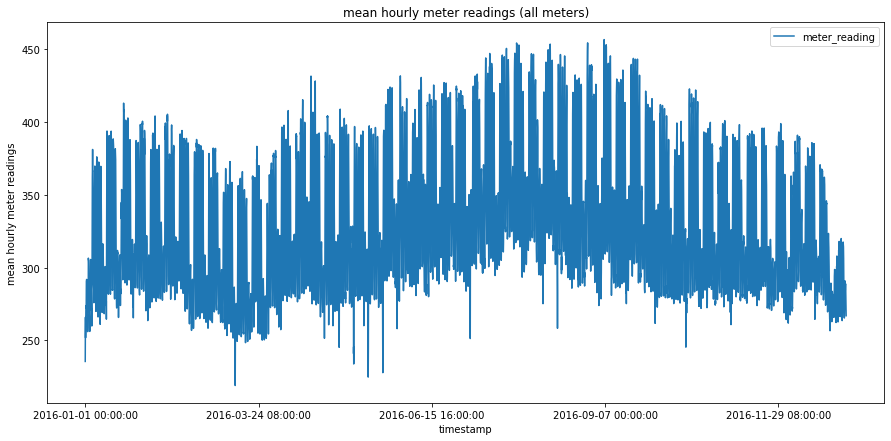

In [65]:
pd_educational.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [35]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_simple_encoding(pd_educational) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [36]:
linear_regression_model, history = learn_parameters(train_data, test_data, 0.00003, 256 )

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-04-17 23:35:59,735:tensorflow] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f7c38d0a3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

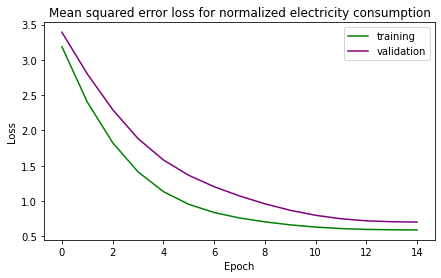

In [37]:
plot_loss_history(history)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-04-17 23:37:07,783:tensorflow] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f7c2b3a33b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. Wh

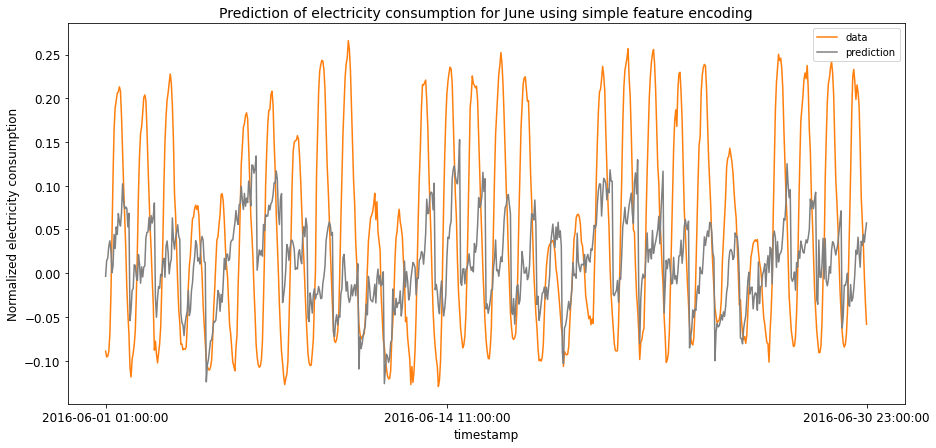

In [38]:
plot_test_and_prediction(test_data, timestamp_test, linear_regression_model, feature_encoding = 'simple')

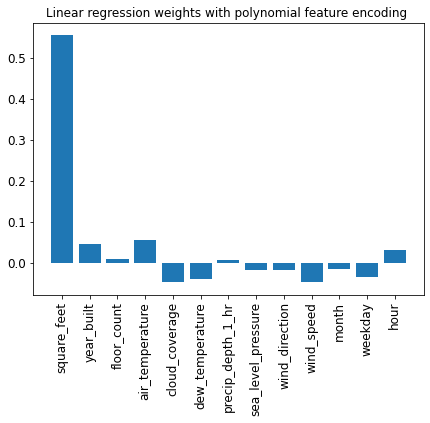

In [39]:
plot_linear_regression_weights(train_data,linear_regression_model)

In [40]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding(pd_educational)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [41]:
linear_regression_model, history = learn_parameters(train_data, test_data, 0.00003, 256 )

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-04-17 23:37:26,044:tensorflow] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f7c2b393cb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

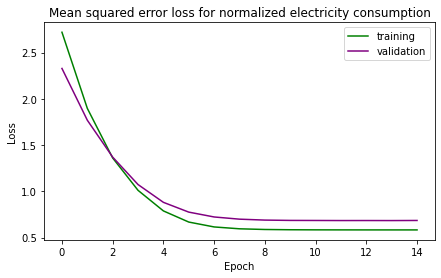

In [42]:
plot_loss_history(history)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[WARNING] [2021-04-17 23:38:31,699:tensorflow] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f7c2b4c2830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. Wh

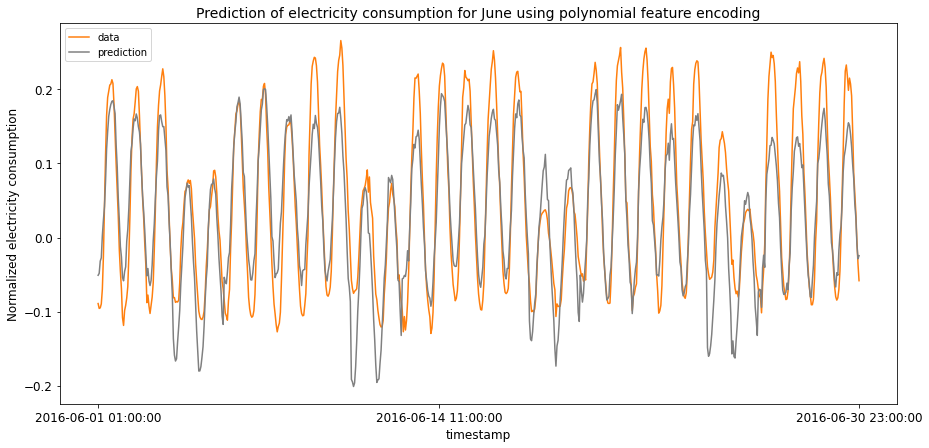

In [43]:
plot_test_and_prediction(test_data, timestamp_test, linear_regression_model, feature_encoding = 'polynomial')

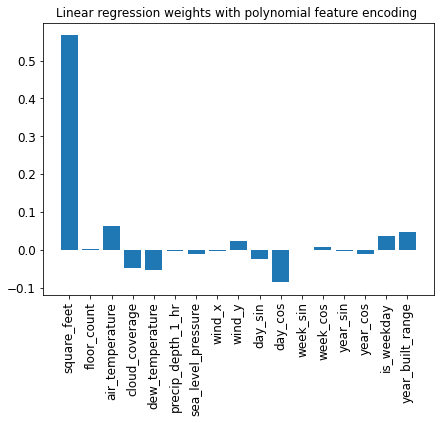

In [44]:
plot_linear_regression_weights(train_data,linear_regression_model, feature_encoding = 'polynomial')

#### Let's look at decision tree:

In [84]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [82]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

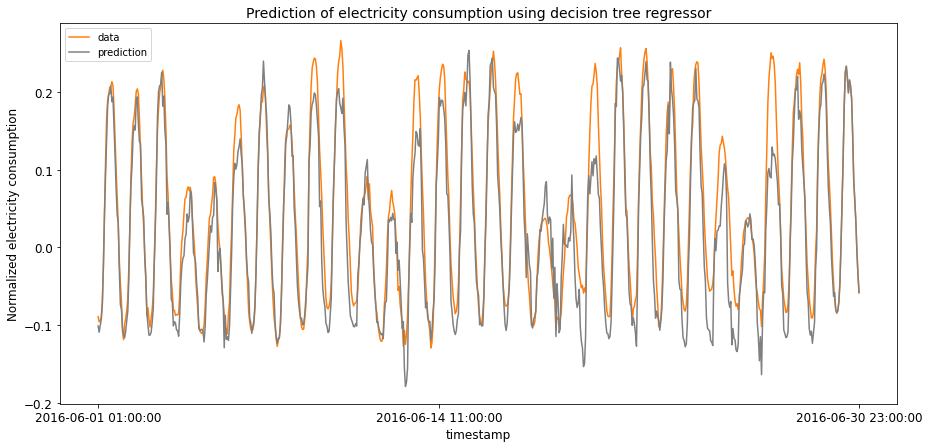

In [83]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

#### Random forest model:

In [91]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

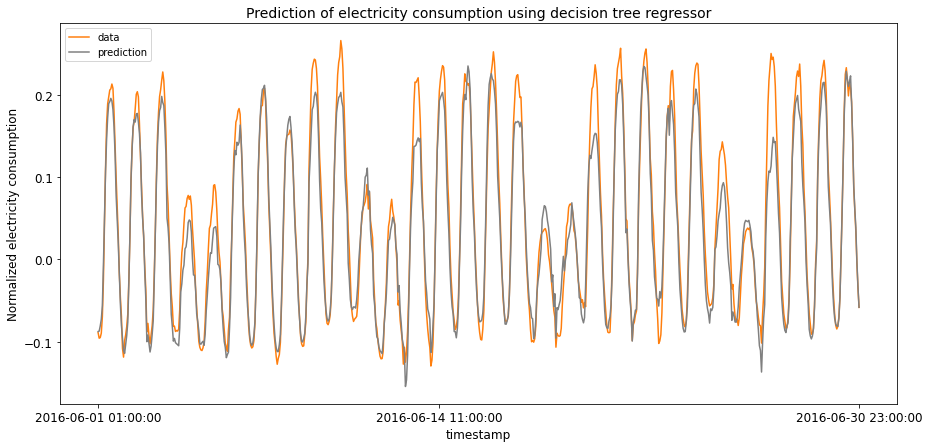

In [92]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

#### Decision tree on not our non-polynomial featured data:

In [45]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

In [46]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
print(list(X_train))

['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [62]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=100)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

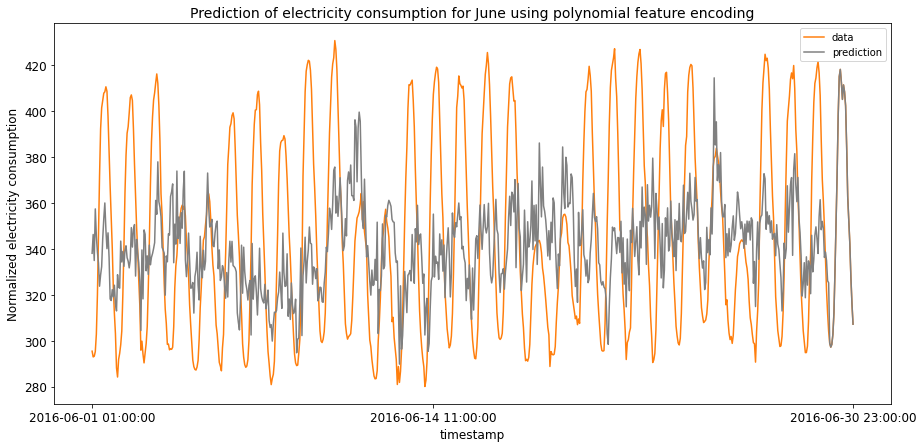

In [63]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption for June using polynomial feature encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

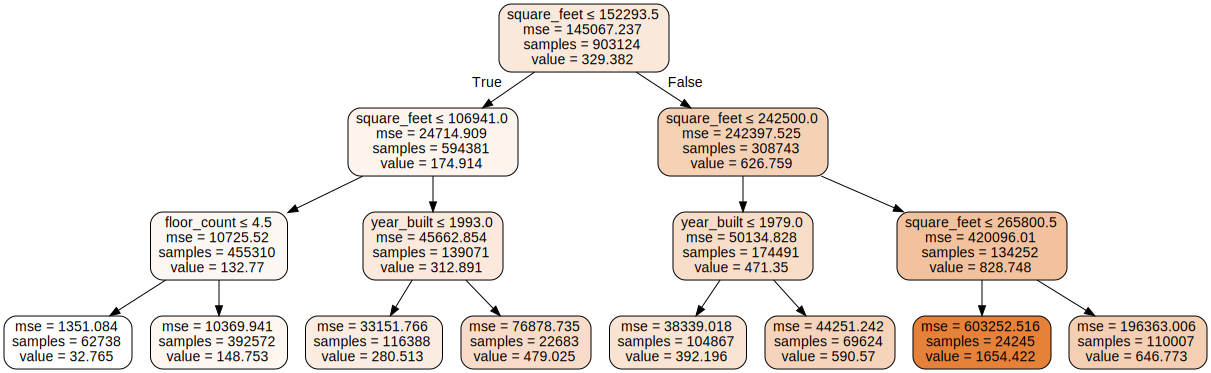

In [57]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=list(X_train),  
                     class_names=['meter_reading'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### 7. Plots for the report:

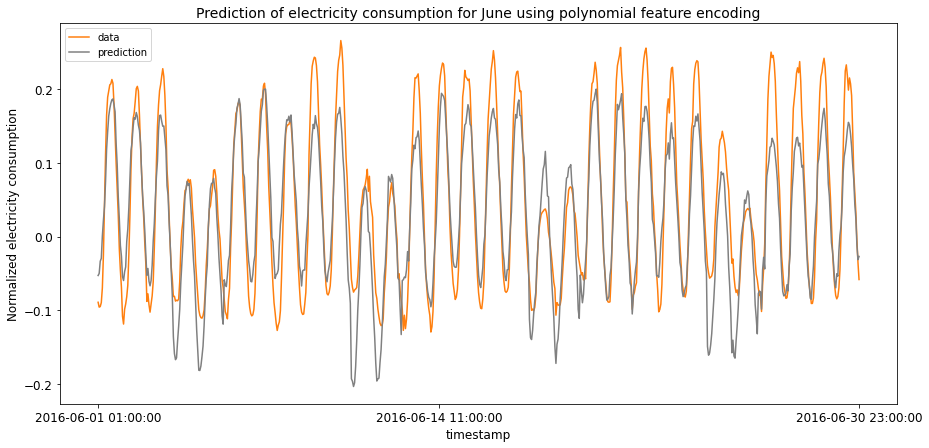

In [23]:
test_features_new_p = test_features_new.copy()
y_norm_p = y_norm.copy()

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption for June using polynomial feature encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

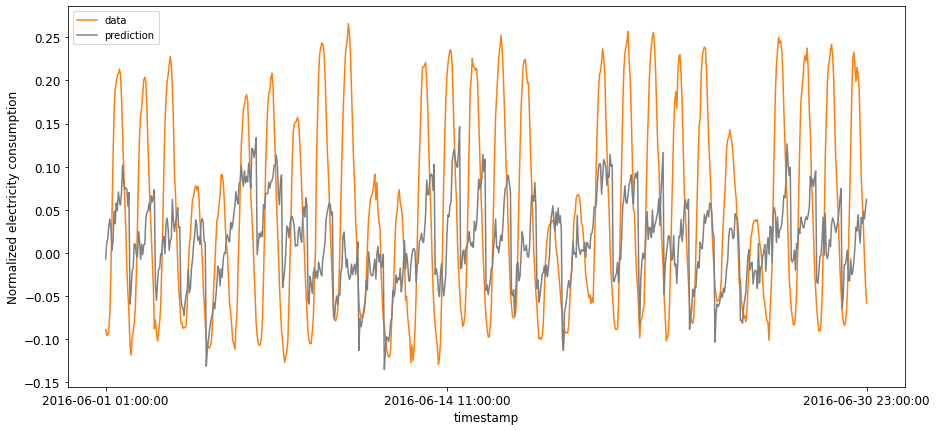

In [102]:
test_features_new_s = test_features_new.copy()
y_norm_s = y_norm.copy()

figure(figsize =(15,7))
plt.plot(test_features_new_s.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_s.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
#plt.title('Prediction of electricity consumption for June using simple feature encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

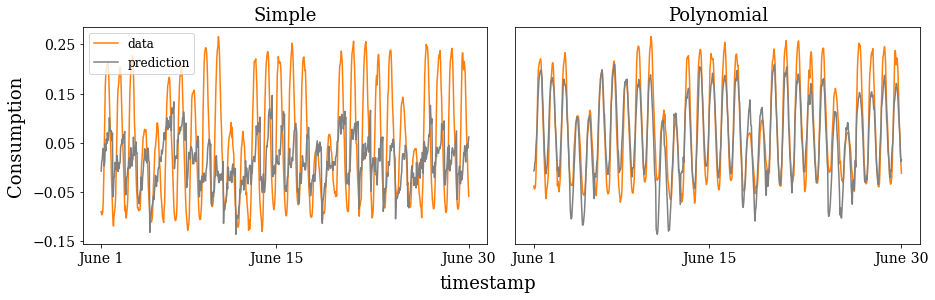

In [220]:
import matplotlib
#matplotlib.rcParams["mathtext.fontset"] = "stix"
#matplotlib.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams["font.weight"] = "normal"

fig = plt.figure(figsize =(15,4))
coord1 = 121
coord2 = 122

len_ts = len(timestamp_test.values)

plt.subplots_adjust(wspace=0.07, hspace=0)

plt.subplot(coord1)
plt.plot(test_features_new_s.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_s.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.title('Simple', fontsize = 18)
len_ts = len(timestamp_test.values)
plt.xticks(ticks = [timestamp_test.values[0],timestamp_test.values[int(len_ts/2)+20],timestamp_test.values[-1] ], labels =['June 1','June 15','June 30'], fontsize = 14)
plt.yticks([0.25,0.15,0.05,-0.05,-0.15],fontsize = 14)
plt.legend(loc = 'upper left' ,fontsize = 12)


plt.subplot(coord2)
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.title('Polynomial', fontsize = 18)
plt.xticks(ticks = [timestamp_test.values[0],timestamp_test.values[int(len_ts/2)+20], timestamp_test.values[-1]], labels =['June 1','June 15','June 30'], fontsize = 14)
#plt.xticks(['2016-06-01 11:00:00'], fontsize = 19)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

fig.text(0.5, -0.03, 'timestamp', ha='center',fontsize = 18)
fig.text(0.055, 0.5, 'Consumption', va='center', rotation='vertical',fontsize = 18)

plt.savefig('LR.pdf', transparency = True,bbox_inches='tight')
plt.show()

In [221]:
timestamp_test.values[-1][:11]

'2016-06-30 '

In [142]:
pd.to_datetime(timestamp_test).dt.date

1718494     2016-06-01
1718497     2016-06-01
1718500     2016-06-01
1718503     2016-06-01
1718506     2016-06-01
               ...    
20064118    2016-06-30
20064119    2016-06-30
20064120    2016-06-30
20064121    2016-06-30
20064122    2016-06-30
Name: timestamp, Length: 81144, dtype: object

In [137]:
timestamp_date = pd.DataFrame(pd.to_datetime(timestamp_test).dt.date)
timestamp_date.values[0]

array([datetime.date(2016, 6, 1)], dtype=object)

In [159]:
timestamp_test.values[-1][:10]

'2016-06-30'

### 8. Autosklearn:

In [5]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

In [6]:
pd_educational

,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,72102,1970.0,5.0,2016-01-01 00:00:00,15.6,6.0,-5.6,0.0,1015.30,270.0,3.6,77.610
1707553,72102,1970.0,5.0,2016-01-01 01:00:00,13.9,4.0,-5.6,0.0,1015.60,270.0,4.1,75.830
1707556,72102,1970.0,5.0,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.00,270.0,3.1,80.570
1707559,72102,1970.0,5.0,2016-01-01 03:00:00,12.2,0.0,-6.1,0.0,1016.60,280.0,3.1,81.530
1707562,72102,1970.0,5.0,2016-01-01 04:00:00,11.7,2.0,-6.7,0.0,1017.00,270.0,3.1,83.550
...,...,...,...,...,...,...,...,...,...,...,...,...
20068262,30143,1951.0,5.0,2016-12-31 19:00:00,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,245.675
20068263,30143,1951.0,5.0,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,250.125
20068264,30143,1951.0,5.0,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,247.875
20068265,30143,1951.0,5.0,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,247.575


In [7]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

In [30]:
X_test

,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1718494,72102,1970.0,5.0,36.1,4.0,-4.4,0.0,1002.2,290.0,5.1
1718497,72102,1970.0,5.0,35.6,4.0,-3.9,0.0,1002.7,250.0,4.1
1718500,72102,1970.0,5.0,34.4,4.0,-4.4,0.0,1003.0,250.0,4.1
1718503,72102,1970.0,5.0,33.3,4.0,-3.3,0.0,1003.6,250.0,2.1
1718506,72102,1970.0,5.0,31.7,4.0,-3.3,0.0,1004.3,240.0,2.1
...,...,...,...,...,...,...,...,...,...,...
20064118,30143,1951.0,5.0,26.1,4.0,9.4,-1.0,1016.5,300.0,2.6
20064119,30143,1951.0,5.0,27.2,2.0,8.9,-1.0,1016.1,200.0,4.1
20064120,30143,1951.0,5.0,25.6,2.0,8.9,-1.0,1015.9,250.0,1.5
20064121,30143,1951.0,5.0,25.6,4.0,8.9,-1.0,1015.6,205.0,2.6


In [34]:
import autosklearn
from autosklearn import *
import autosklearn.regression
#import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=1200)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)

In [35]:
print(automl.show_models())

[(0.640000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'sgd', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.010000000000000004, 'feature_preprocessor:polynomial:degree': 3, 'feature_preprocessor:polynomial:include_bias': 'True', 'feature_preprocessor:polynomial:interaction_only': 'False', 'regressor:sgd:alpha': 7.395586042195198e-06, 'regressor:sgd:average': 'True', 'regressor:sgd:fit_intercept': 'True', 'regressor:sgd:learning_rate': 'optimal', 'regressor:sgd:loss': 'epsilon_insensitive', 'regressor:sgd:penalty': 'l2', 'regresso

In [36]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

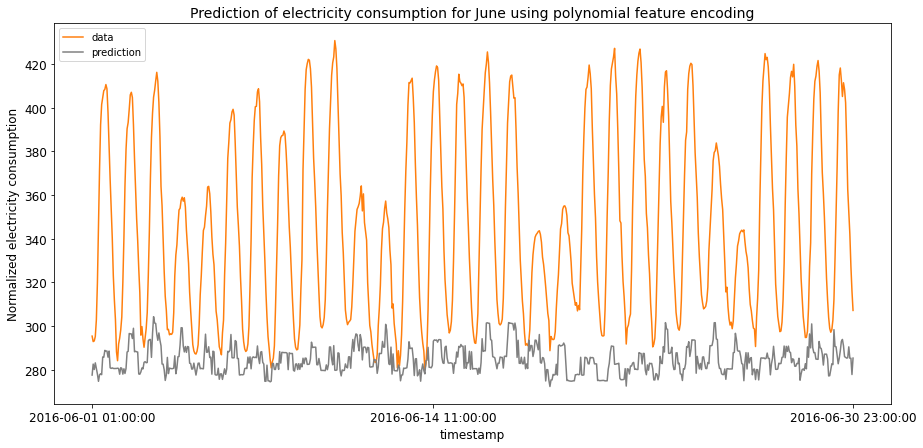

In [37]:
figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption for June using polynomial feature encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

#### One building:

In [5]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
ids5 = pd_educational.building_id.unique()[:5]
pd_educational = pd_educational[pd_educational.building_id.isin(ids5)]
features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

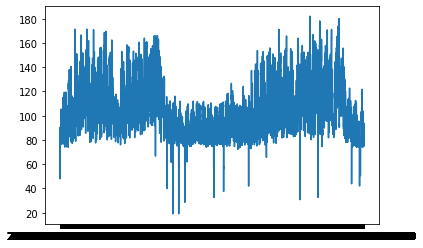

In [56]:
plt.plot(pd_educational.timestamp,pd_educational.meter_reading)
plt.show()

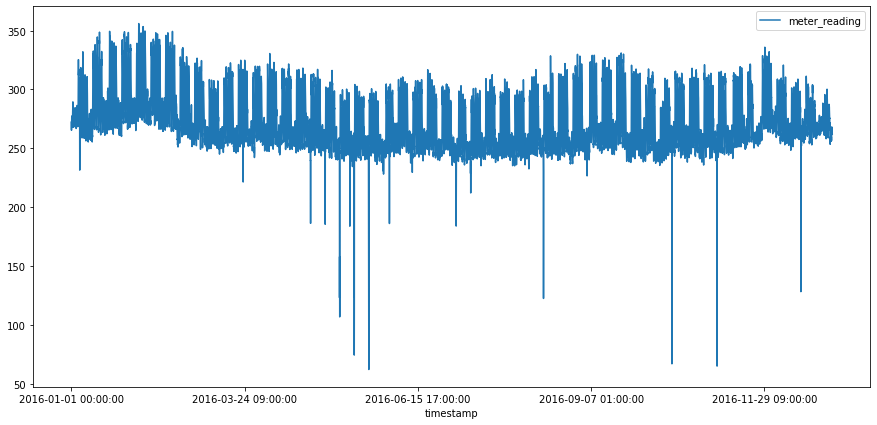

In [6]:
pd_educational.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7))

In [7]:
pd_train = pd.concat([pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 6, 1)] , pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 30)]])
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 6, 1)] 
pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

In [9]:
X_test

,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1718494,72102,1970.0,5.0,36.1,4.0,-4.4,0.0,1002.2,290.0,5.1
1718497,72102,1970.0,5.0,35.6,4.0,-3.9,0.0,1002.7,250.0,4.1
1718500,72102,1970.0,5.0,34.4,4.0,-4.4,0.0,1003.0,250.0,4.1
1718503,72102,1970.0,5.0,33.3,4.0,-3.3,0.0,1003.6,250.0,2.1
1718506,72102,1970.0,5.0,31.7,4.0,-3.3,0.0,1004.3,240.0,2.1
...,...,...,...,...,...,...,...,...,...,...
1944447,90900,1963.0,5.0,31.1,6.0,18.3,0.0,1011.9,120.0,2.6
1944449,90900,1963.0,5.0,31.7,6.0,18.3,0.0,1010.9,50.0,2.1
1944451,90900,1963.0,5.0,32.8,6.0,17.2,0.0,1010.3,90.0,2.1
1944453,90900,1963.0,5.0,34.4,6.0,17.2,0.0,1009.5,180.0,4.1


In [10]:
import autosklearn
from autosklearn import *
import autosklearn.regression
#import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=240, n_jobs = -1)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)

/usr/local/lib/python3.7/dist-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [11]:
print(automl.show_models())

[(0.980000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'extra_trees', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.0033650478527174027, 'regressor:extra_trees:bootstrap': 'True', 'regressor:extra_trees:criterion': 'friedman_mse', 'regressor:extra_trees:max_depth': 'None', 'regressor:extra_trees:max_features': 0.7303174358688075, 'regressor:extra_trees:max_leaf_nodes': 'None', 'regressor:extra_trees:min_impurity_decrease': 0.0, 'regressor:extra_trees:min_samples_leaf': 10, 'regressor:extra_trees:min_samples_split': 10, 'regresso

In [12]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

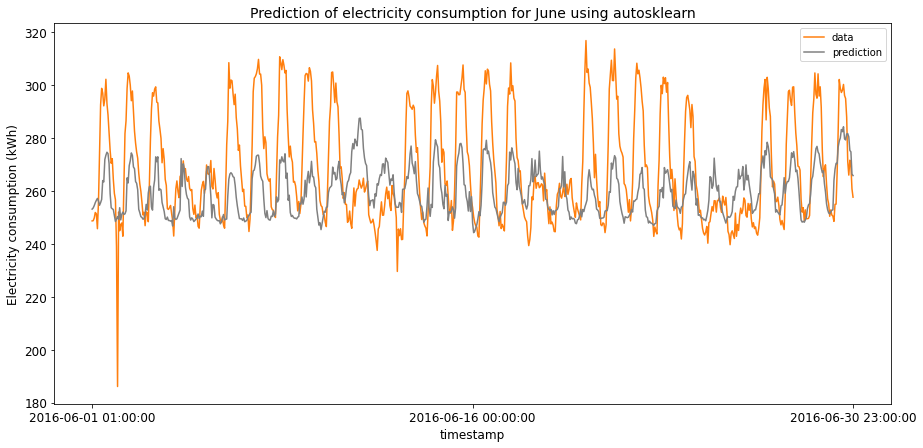

In [14]:
figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption for June using autosklearn', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()